# <font color ='blue'>Bangaluru House Price Prediction

Dataset is downloaded from here :
https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import pickle
import json

# <font color = 'blue'>Load the data into a DataFrame

In [6]:
# Load the dataset from a CSV file
df = pd.read_csv('C:/Users/rayah/Downloads/ML_Portfolio_Projects/Bangaluru_House_Price_Prediction/Bengaluru_House_Data.csv')

# Display the first few rows of the dataset
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [7]:
# Get the number of rows and columns in the DataFrame
num_rows, num_cols = df.shape

# Print the shape of the DataFrame
print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")


Number of rows: 13320, Number of columns: 9


In [8]:
# Print the column names of the DataFrame
print(df.columns)

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [9]:
# Retrieve the unique values in the 'area_type' column of the DataFrame
unique_area_types = df['area_type'].unique()
print(unique_area_types)

['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']


In [10]:
# Get the count of unique values in the 'area_type' column of the DataFrame
area_type_counts = df['area_type'].value_counts()
print(area_type_counts)

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64


**Drop features that are not required to build our model**

In [12]:
# Drop unnecessary columns from the DataFrame to reduce dimensionality and improve model performance
df = df.drop(['area_type', 'society', 'balcony', 'availability'], axis=1)  # Remove specified columns from the DataFrame

# Verify the new shape of the DataFrame after dropping columns
print("New shape of the DataFrame:", df.shape)

New shape of the DataFrame: (13320, 5)


## <font color = 'blue'> Data Cleaning: Handle NA values

In [14]:
# Check for missing values in the DataFrame
missing_value_count = df.isna().sum()

# Return the count of missing values for each column
print("Missing values count:", missing_value_count)


Missing values count: location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64


In [15]:
# Get the shape of the DataFrame, which returns a tuple containing the number of rows and the number of columns
df_shape = df.shape

# Print the shape of the DataFrame in a readable format
print("DataFrame Shape:", df_shape)


DataFrame Shape: (13320, 5)


In [16]:
# Remove rows with any missing values
df = df.dropna()

# Check and display the count of missing values in each column
missing_values_count = df.isna().sum()  # Calculate the number of missing values for each column
print("Missing values count after removing rows:", missing_values_count)

# Print the shape of the DataFrame (number of rows and columns)
print("DataFrame shape after removing rows:", df.shape)


Missing values count after removing rows: location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64
DataFrame shape after removing rows: (13246, 5)


## <font color = 'blue'>Feature Engineering

**Add new feaurees (interger) for bhk (Bedrooms Hall Kitchen)**

In [19]:
# Accessing the 'size' column of the DataFrame 'df' and getting the unique values in that column
unique_sizes = df['size'].unique()  # Retrieve unique values from the 'size' column
print("Unique sizes:", unique_sizes)


Unique sizes: ['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' '9 Bedroom' '27 BHK' '10 Bedroom'
 '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom' '14 BHK' '8 BHK'
 '12 Bedroom' '13 BHK' '18 Bedroom']


In [20]:
# Extract the number of bedrooms (BHK) from the 'size' column
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))  # Split the string, take the first element, and convert to integer

# Print the unique values in the 'bhk' column
print("Unique BHK values:", df.bhk.unique())


Unique BHK values: [ 2  4  3  6  1  8  7  5 11  9 27 10 19 16 43 14 12 13 18]


In [21]:
# Filter the DataFrame 'df' to include only rows where the 'bhk' column value is greater than 20
filtered_df = df[df['bhk'] > 20]
print("Filtered DataFrame:", filtered_df)


Filtered DataFrame:                        location        size total_sqft  bath  price  bhk
1718  2Electronic City Phase II      27 BHK       8000  27.0  230.0   27
4684                Munnekollal  43 Bedroom       2400  40.0  660.0   43


In [22]:
# Extract the unique values from the 'total_sqft' column
unique_sqft_values = df['total_sqft'].unique()

# Print the unique values
print("Unique values in 'total_sqft' column:")
print(unique_sqft_values)

Unique values in 'total_sqft' column:
['1056' '2600' '1440' ... '1133 - 1384' '774' '4689']


**Explore total_sqft feature**

In [24]:
# Define a function to check if a value can be converted to a float
def is_float(x):
    """
    Checks if the given input 'x' can be converted to a float.
    
    Args:
        x (str or any): The input to be checked.
    
    Returns:
        bool: True if the input can be converted to a float, False otherwise.
    """
    try:
        # Attempt to convert the input to a float
        float(x)  # This line tries to convert 'x' to a float
    except:
        # If the conversion fails, return False
        return False  # Return False if an exception occurs during conversion
    # If the conversion succeeds, return True
    return True  # Return True if the conversion is successful


In [25]:
# Filter the dataframe to show rows where 'total_sqft' is not a float
non_float_sqft = df[~df['total_sqft'].apply(is_float)].head(10)
print("Rows where 'total_sqft' is not a float:", non_float_sqft)


Rows where 'total_sqft' is not a float:                location       size      total_sqft  bath    price  bhk
30            Yelahanka      4 BHK     2100 - 2850   4.0  186.000    4
122              Hebbal      4 BHK     3067 - 8156   4.0  477.000    4
137  8th Phase JP Nagar      2 BHK     1042 - 1105   2.0   54.005    2
165            Sarjapur      2 BHK     1145 - 1340   2.0   43.490    2
188            KR Puram      2 BHK     1015 - 1540   2.0   56.800    2
410             Kengeri      1 BHK  34.46Sq. Meter   1.0   18.500    1
549         Hennur Road      2 BHK     1195 - 1440   2.0   63.770    2
648             Arekere  9 Bedroom       4125Perch   9.0  265.000    9
661           Yelahanka      2 BHK     1120 - 1145   2.0   48.130    2
672        Bettahalsoor  4 Bedroom     3090 - 5002   4.0  445.000    4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [27]:
# Define a function to convert square footage strings to numeric values
def convert_sqft_to_num(x):
    """
    Converts a square footage string to a numeric value.

    Args:
        x (str): The square footage string, which can be in the format of a single number or a range separated by a hyphen.

    Returns:
        float or None: The numeric value of the square footage. If the input string cannot be converted, it returns None.
    """
    # Split the input string by the hyphen to check if it's a range
    tokens = x.split('-')
    
    # If the input is a range, calculate the average of the two values
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    
    # If the input is a single number, try to convert it to a float
    try:
        return float(x)
    # If the conversion fails, return None
    except:
        return None


In [28]:
# Create a copy of the original DataFrame
df1 = df.copy()

# Apply the function to the 'total_sqft' column to convert it to a numerical value
df1['total_sqft'] = df1['total_sqft'].apply(convert_sqft_to_num)

# Display the first 3 rows of the modified DataFrame
print("Modified DataFrame:", df1.head(3))


Modified DataFrame:                    location       size  total_sqft  bath   price  bhk
0  Electronic City Phase II      2 BHK      1056.0   2.0   39.07    2
1          Chikka Tirupathi  4 Bedroom      2600.0   5.0  120.00    4
2               Uttarahalli      3 BHK      1440.0   2.0   62.00    3


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [30]:
# Access the row at index 30 of the DataFrame df1
row_30 = df1.loc[30]  # Using the .loc method to retrieve the row by its index

# Print or use the row as needed
print("Row 30:", row_30)

Row 30: location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object


**Add new feature called price per square feet**

In [32]:
# Create a copy of the original dataframe to avoid modifying it
df2 = df1.copy()

# Calculate the price per square foot
# Convert price to rupees (multiply by 100000) and divide by total square feet
df2['price_per_sqft'] = (df2['price'] * 100000) / df2['total_sqft']

# Display the first few rows of the updated dataframe to verify the changes
print("Updated DataFrame:", df2.head())

Updated DataFrame:                    location       size  total_sqft  bath   price  bhk  \
0  Electronic City Phase II      2 BHK      1056.0   2.0   39.07    2   
1          Chikka Tirupathi  4 Bedroom      2600.0   5.0  120.00    4   
2               Uttarahalli      3 BHK      1440.0   2.0   62.00    3   
3        Lingadheeranahalli      3 BHK      1521.0   3.0   95.00    3   
4                  Kothanur      2 BHK      1200.0   2.0   51.00    2   

   price_per_sqft  
0     3699.810606  
1     4615.384615  
2     4305.555556  
3     6245.890861  
4     4250.000000  


In [33]:
# Display descriptive statistics of the 'price_per_sqft' column
# This will include count, mean, standard deviation, min, 25th percentile, median, 75th percentile, and max values
df2.price_per_sqft.describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [35]:
# Get the unique locations from the 'location' column
unique_locations = df2['location'].unique()

# Calculate the number of unique locations using the len() function
num_unique_locations = len(unique_locations)

# Print the result, which is the count of unique locations found in the DataFrame
print(num_unique_locations)

1304


In [36]:
# Strip whitespace from 'location' column values
df2.location = df2.location.apply(lambda x: x.strip())

# Count occurrences of each unique location, sorted in descending order
location_stats = df2['location'].value_counts(ascending=False)

# Display the location statistics
print(location_stats)

location
Whitefield                        535
Sarjapur  Road                    392
Electronic City                   304
Kanakpura Road                    266
Thanisandra                       236
                                 ... 
Vasantapura main road               1
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Abshot Layout                       1
Name: count, Length: 1293, dtype: int64


In [37]:
# Count the number of locations with a value less than or equal to 10
# This line filters the 'location_stats' DataFrame to include only those locations
# where the value is less than or equal to 10, and then calculates the length
# of the resulting filtered DataFrame to get the count of such locations.
num_locations_10_or_less = len(location_stats[location_stats <= 10])

# Print the result
# This line outputs the count of locations with a value of 10 or less
# in a formatted string for better readability.
print(f"The number of locations with a value of 10 or less is: {num_locations_10_or_less}")

The number of locations with a value of 10 or less is: 1052


In [38]:
# Get the number of unique locations in the 'location' column of the DataFrame 'df2'
# The 'unique()' method returns an array of unique values from the specified column
num_unique_locations = len(df2.location.unique())

# Print the number of unique locations
# The 'print()' function outputs the result to the console, formatted with an f-string
print(f"The number of unique locations is: {num_unique_locations}")

The number of unique locations is: 1293


## <font color = 'blue'>Dimensionality Reduction

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [41]:
# Filter the 'location_stats' series or dataframe to include only those values
# that are less than or equal to 10.
location_stats_less_than_10 = location_stats[location_stats <= 10]

# Display the filtered 'location_stats_less_than_10'
# This will show all entries from 'location_stats' that meet the filtering criteria.
location_stats_less_than_10

location
Naganathapura                     10
Sadashiva Nagar                   10
Nagappa Reddy Layout              10
BTM 1st Stage                     10
Sector 1 HSR Layout               10
                                  ..
Vasantapura main road              1
Bapuji Layout                      1
1st Stage Radha Krishna Layout     1
BEML Layout 5th stage              1
Abshot Layout                      1
Name: count, Length: 1052, dtype: int64

In [42]:
# Recategorize locations with less than 10 occurrences as 'others'
df2.location = df2.location.apply(
    # Use a lambda function to check each location
    lambda x: 'others' if x in location_stats_less_than_10 else x
)

# Get the number of unique locations after recategorization
num_unique_locations = len(df2.location.unique())  # Count unique locations in the updated 'location' column
num_unique_locations  # Display the number of unique locations

242

In [43]:
# Display the first 5 rows of the DataFrame
# This function call retrieves and shows the top 5 entries of the DataFrame 'df2'
df2.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


## <font color = 'blue'>Outlier Removal Using Business Logic

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [46]:
# Filter the dataframe df2 to include only rows where the total square footage per bedroom (bhk) is less than 300
# This condition helps in identifying properties that may be overvalued based on their size per bedroom
filtered_df = df2[df2.total_sqft / df2.bhk < 300]

# Display the first few rows of the filtered dataframe
# This allows us to quickly inspect the results of the filtering operation
filtered_df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,others,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,others,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [48]:
# Get the shape of the DataFrame df2, which returns a tuple representing 
# the number of rows and columns in the DataFrame.
df2.shape

(13246, 7)

In [49]:
# Filter out rows where the total square footage per BHK is less than 300
df2 = df2[~(df2.total_sqft/df2.bhk < 300)]

# Get the shape of the DataFrame after filtering
df2.shape

(12502, 7)

## <font color = 'blue'> Outlier Removal Using Standard Deviation and Mean

In [51]:
# Describe the price_per_sqft column
print(df2.price_per_sqft.describe())

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64


**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [53]:
# Define a function to remove price per square foot outliers
def remove_pps_outliers(df):
    """
    This function removes outliers from the price per square foot data.
    It does this by calculating the mean and standard deviation of the price per square foot for each location,
    and then removing any data points that are more than one standard deviation away from the mean.
    
    Args:
    df (pandas.DataFrame): The input dataframe.
    
    Returns:
    pandas.DataFrame: The dataframe with outliers removed.
    """
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

# Remove outliers from df2 and print the new shape
df2 = remove_pps_outliers(df2)
print(df2.shape)

(10241, 7)


**Lets check if for a given location how does the 2 BHK and 3 BHK property prices look like**

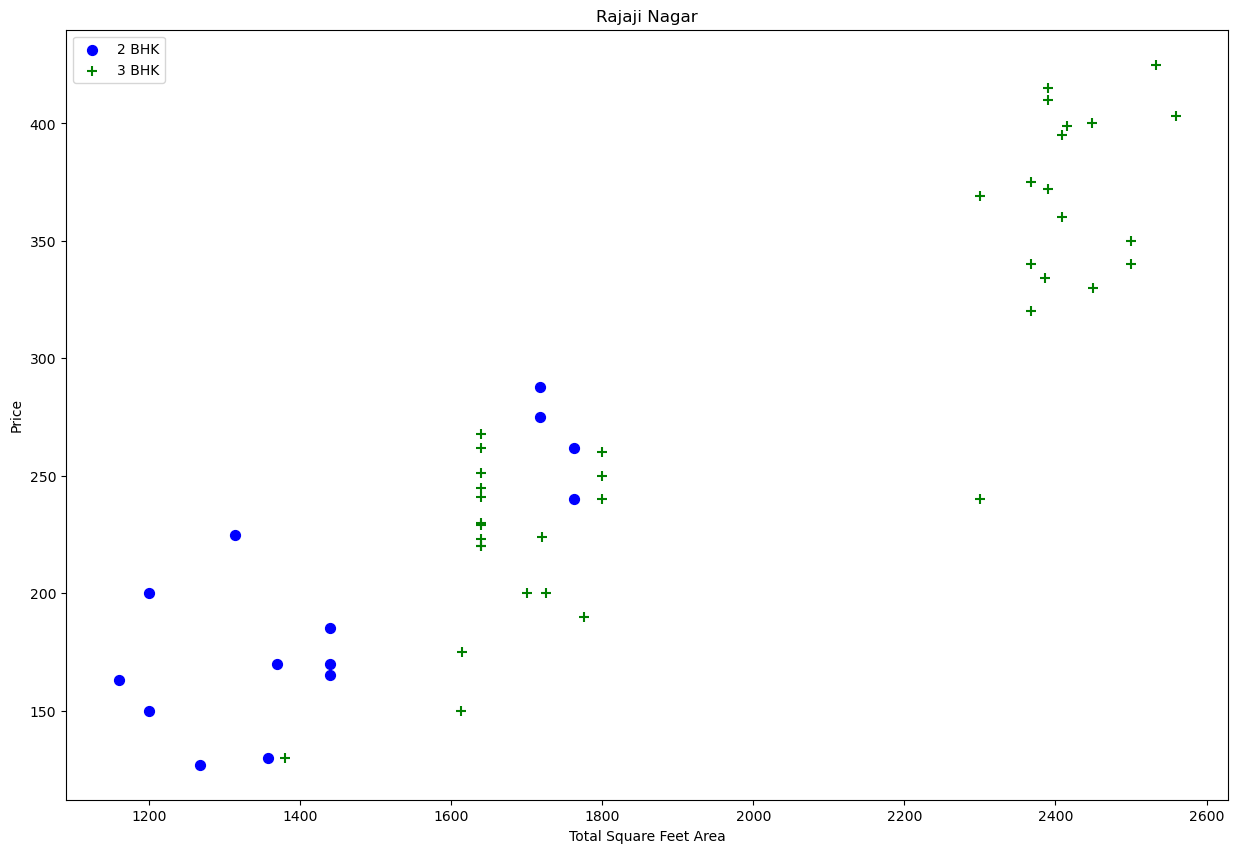

In [55]:
# Define a function to plot a scatter chart for a given location
def plot_scatter_chart(df, location):
    """
    This function plots a scatter chart of the price vs. total square feet area for a given location,
    with different colors for 2 BHK and 3 BHK properties.
    
    Args:
    df (pandas.DataFrame): The input dataframe.
    location (str): The location to plot the chart for.
    """
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

# Plot the scatter chart for Rajaji Nagar
plot_scatter_chart(df2, 'Rajaji Nagar')

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**

{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'coun4
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        t: 22
        

 
**   },    
}
Now we can remove those 2 BHK apartments whose price_pe than mean price_per_sqft of 1 BHK apartment**sqft is less**

In [57]:
# Define a function to remove BHK outliers
def remove_bhk_outliers(df):
    """
    This function removes outliers from the BHK data.
    It does this by calculating the mean and standard deviation of the price per square foot for each BHK category
    in each location, and then removing any data points that are less than the mean of the previous BHK category.
    
    Args:
    df (pandas.DataFrame): The input dataframe.
    
    Returns:
    pandas.DataFrame: The dataframe with outliers removed.
    """
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

# Remove BHK outliers from df2 and print the new shape
df2 = remove_bhk_outliers(df2)
print(df2.shape)

(7329, 7)


**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

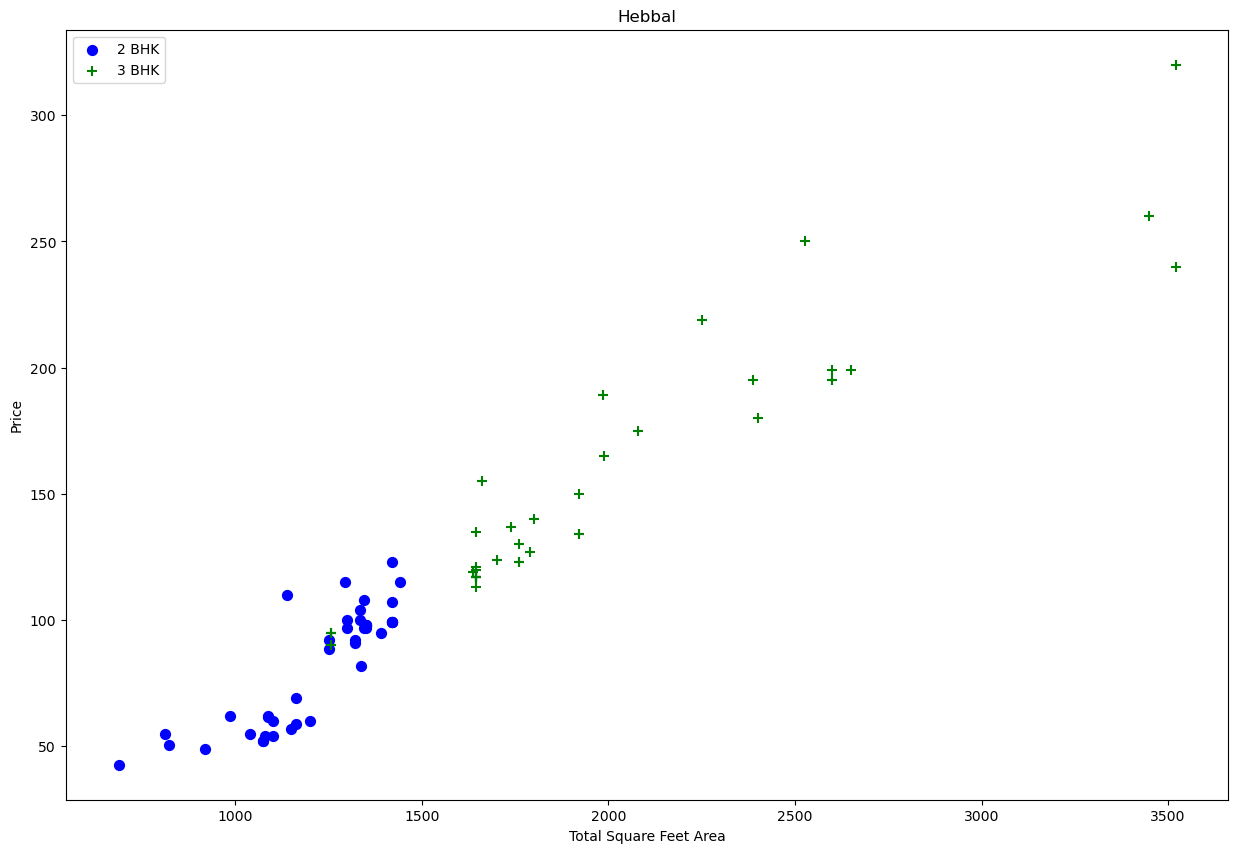

In [59]:
# Plot the scatter chart for Hebbal
plot_scatter_chart(df2, 'Hebbal')

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

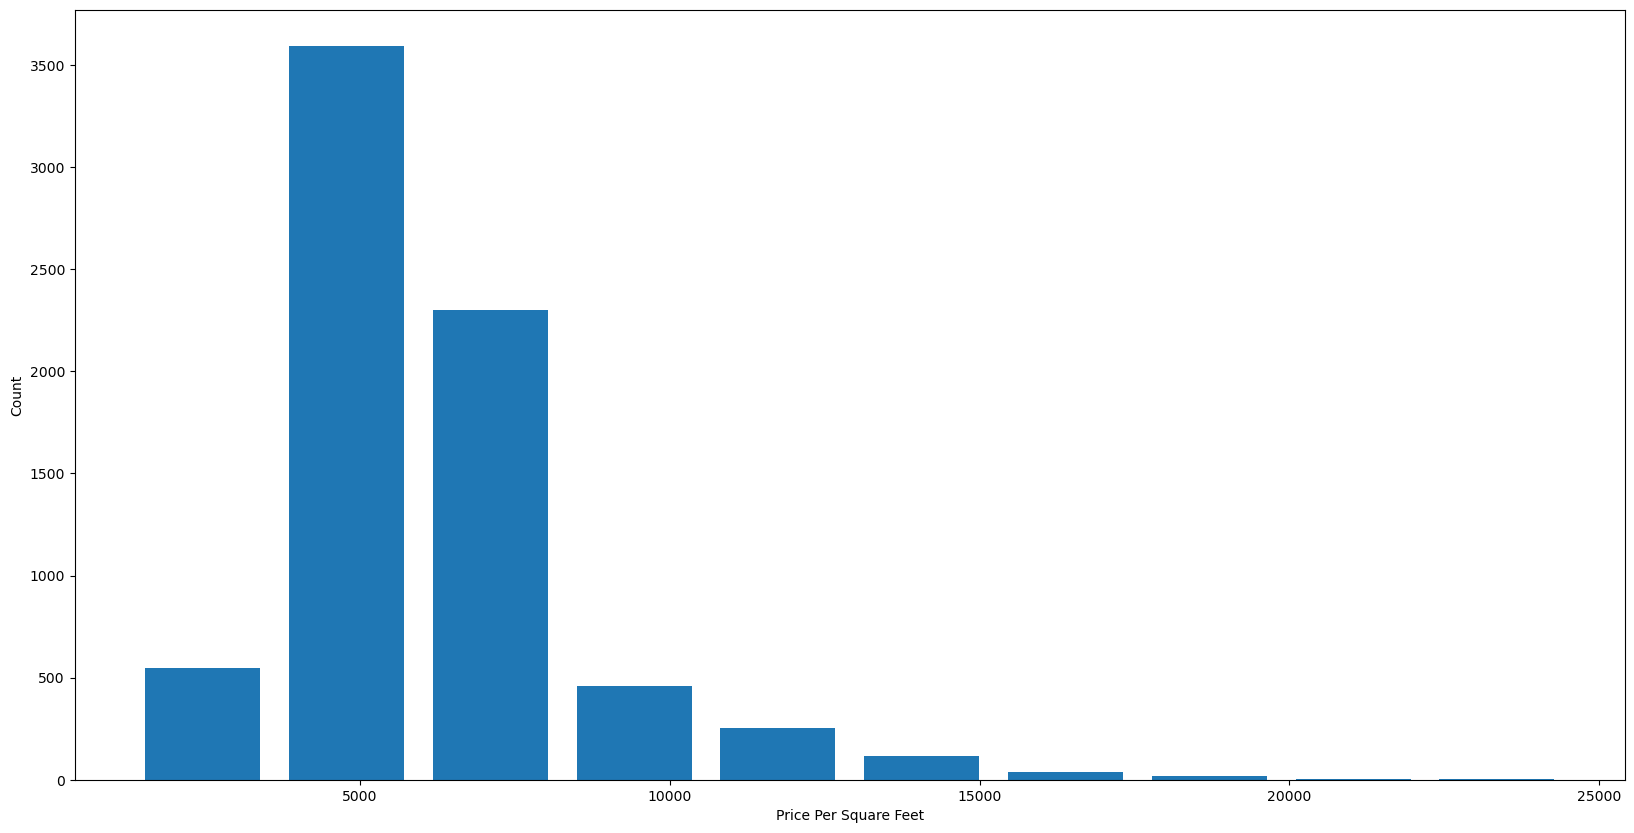

In [61]:
# Plot a histogram of the price per square foot
matplotlib.rcParams['figure.figsize'] = (20, 10)
plt.hist(df2.price_per_sqft, rwidth=0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')
plt.show()

## <font color = 'blue'>Outlier Removal Using Bathrooms Feature

In [63]:
# Print the unique values of the bath column
print(df2.bath.unique())


[ 4.  3.  2.  5.  8.  1.  6.  7.  9. 12. 16. 13.]


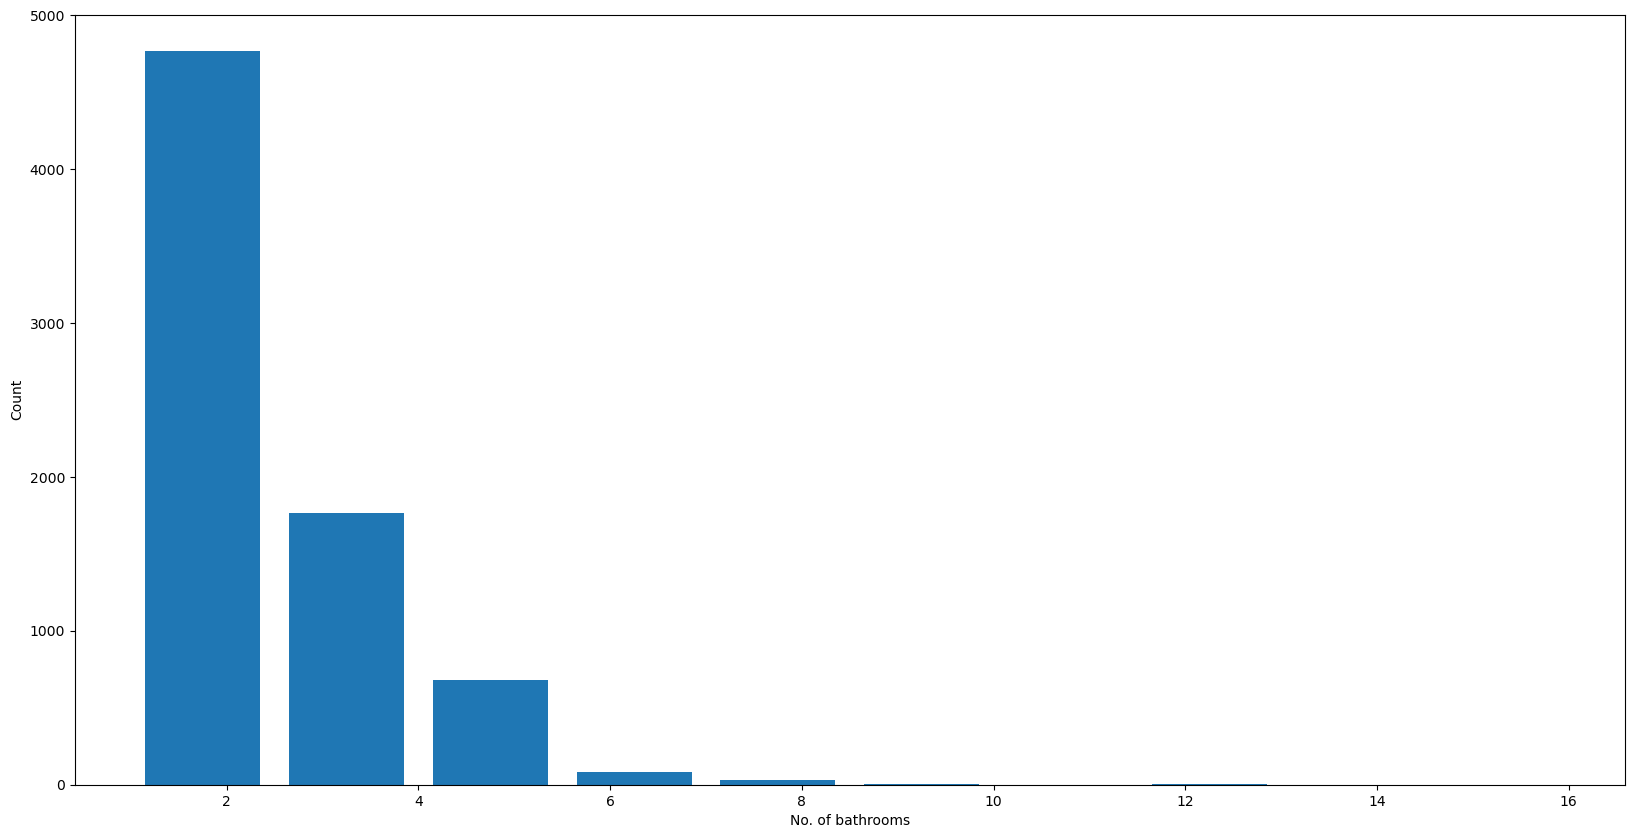

In [64]:
# Plot a histogram of the number of bathrooms
plt.hist(df2.bath, rwidth=0.8)
plt.xlabel('No. of bathrooms')
plt.ylabel('Count')
plt.show()

In [65]:
# Print the rows where the number of bathrooms is greater than 10
print(df2[df2.bath > 10])


            location    size  total_sqft  bath  price  bhk  price_per_sqft
5277  Neeladri Nagar  10 BHK      4000.0  12.0  160.0   10     4000.000000
8486          others  10 BHK     12000.0  12.0  525.0   10     4375.000000
8575          others  16 BHK     10000.0  16.0  550.0   16     5500.000000
9308          others  11 BHK      6000.0  12.0  150.0   11     2500.000000
9639          others  13 BHK      5425.0  13.0  275.0   13     5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [67]:
# Remove rows where the number of bathrooms is greater than the number of bedrooms + 2
df2 = df2[df2.bath < df2.bhk + 2]
df2.shape

(7251, 7)

**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [69]:
# Drop the 'size' and 'price_per_sqft' columns
df2 = df2.drop(['size', 'price_per_sqft'], axis=1)
df2.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


## <font color = 'blue'>Use One Hot Encoding For Location

In [71]:
# Create dummy variables for the 'location' column
dummies = pd.get_dummies(df2.location, dtype=int)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,others
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Concatenate the dummy variables with the original dataframe
df3 = pd.concat([df2, dummies.drop('others', axis=1)], axis=1)
df3

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,others,1200.0,2.0,70.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10233,others,1800.0,1.0,200.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10236,others,1353.0,2.0,110.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,others,812.0,1.0,26.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Drop the 'location' column
df3 = df3.drop('location', axis=1)
df3.shape


(7251, 245)

## <font color = 'blue'>Build a Model Now..

In [75]:
# Split the data into X (features) and y (target)
X = df3.drop('price', axis=1)
y = df3.price

In [76]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [77]:
# Train a linear regression model and print the test score
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
print(lr_clf.score(X_test, y_test))

0.8452277697874324


## <font color = 'blue'>Evaluating Linear Regression with K-Fold Cross-Validation

In [79]:
# Perform cross-validation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(cross_val_score(LinearRegression(), X, y, cv=cv))


[0.82430186 0.77166234 0.85089567 0.80837764 0.83653286]


## <font color = 'blue'>Find best model using GridSearchCV

In [81]:
# Define a function to find the best model using GridSearchCV
def find_best_model_using_gridsearchcv(X, y):
    """
    This function uses GridSearchCV to find the best model and hyperparameters for the given data.
    It compares the performance of three different models: linear regression, Lasso, and decision tree regression.
    
    Args:
    X (pandas.DataFrame): The feature data.
    y (pandas.Series): The target variable.
    
    Returns:
    pandas.DataFrame: A dataframe containing the best score and best parameters for each model.
    """
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# Use the find_best_model_using_gridsearchcv function
find_best_model_using_gridsearchcv(X, y)


,model,best_score,best_params
0,linear_regression,0.819001,"{'fit_intercept': False, 'positive': False}"
1,lasso,0.687456,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.726638,"{'criterion': 'squared_error', 'splitter': 'be..."


## <font color = 'blue'>Test the model for few properties

In [83]:
import warnings
warnings.filterwarnings('ignore')
# Define a function to predict the price of a property
def predict_price(location, sqft, bath, bhk):
    """
    This function predicts the price of a property based on its location, square footage, number of bathrooms, and number of bedrooms.
    
    Args:
    location (str): The location of the property.
    sqft (int): The total square footage of the property.
    bath (int): The number of bathrooms in the property.
    bhk (int): The number of bedrooms in the property.
    
    Returns:
    float: The predicted price of the property.
    """
    loc_index = np.where(X.columns == location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

# Test the predict_price function
print(predict_price('1st Phase JP Nagar', 1000, 2, 2))
print(predict_price('1st Phase JP Nagar', 1000, 2, 3))
print(predict_price('Indira Nagar', 1000, 2, 2))
print(predict_price('Indira Nagar', 1000, 3, 3))


83.49904677185246
81.72616900760876
181.2781548400676
184.58430202033406


## <font color = 'blue'>Export Model and Metadata

In [85]:
# Save the trained model and column names to files
with open('bangalore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))